<a href="https://colab.research.google.com/github/jarinari/Algorithmic-Trading-Plugins/blob/master/Lot_Sizing_Backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1 - Import test data

In [ ]:
import pandas as pd
import pandas_ta as ta

df = pd.read_csv("EURUSD_Candlestick_5_M_BID_01.02.2023-17.02.2024.csv")
df["Gmt time"]=df["Gmt time"].str.replace(".000","")
df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%d.%m.%Y %H:%M:%S')
df=df[df.High!=df.Low]
df.set_index("Gmt time", inplace=True)

In [ ]:
df['RSI']=ta.rsi(df.Close, length=10)
my_bbands = ta.bbands(df.Close, length=15, std=1.5)
df['ATR']=ta.atr(df.High, df.Low, df.Close, length=7)
df=df.join(my_bbands)

In [ ]:
def bollinger_signal(df):
    condition_buy = df['Close'] <= df['BBL_15_1.5']
    condition_sell = df['Close'] >= df['BBU_15_1.5']

    df['bollinger_Signal'] = 0  # Default no signal
    df.loc[condition_buy, 'bollinger_Signal'] = 2
    df.loc[condition_sell, 'bollinger_Signal'] = 1
bollinger_signal(df)

In [ ]:
import numpy as np
def calculate_rsi_signal_windowed(rsi_series):
    rsi_signal = np.zeros(len(rsi_series))
    for i in range(len(rsi_series)):
        window_start = max(0, i - 5)  # Adjusting to the correct window size
        window = rsi_series[window_start:i]  # Excludes the current value, as intended
        # Apply conditions within the window
        if not window.empty and window.gt(50.1).all():
            rsi_signal[i] = 2
        elif not window.empty and window.lt(49.9).all():
            rsi_signal[i] = 1
        # Else, it remains 0
    return rsi_signal

# Apply the function to calculate RSI_signal
df['RSI_signal'] = calculate_rsi_signal_windowed(df['RSI'])
df['TotalSignal'] = df.apply(lambda row: row['bollinger_Signal'] if row['bollinger_Signal'] == row['RSI_signal'] else 0, axis=1)

In [ ]:
df.TotalSignal.value_counts()

TotalSignal
0.0    60684
2.0      362
1.0      305
Name: count, dtype: int64

In [ ]:
import numpy as np
def pointpos(x):
    if x['TotalSignal']==2:
        return x['Low']-1e-4
    elif x['TotalSignal']==1:
        return x['High']+1e-4
    else:
        return np.nan

df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=100
dfpl = df[st:st+350]
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),

                go.Scatter(x=dfpl.index, y=dfpl['BBL_15_1.5'],
                           line=dict(color='green', width=1),
                           name="BBL"),
                go.Scatter(x=dfpl.index, y=dfpl['BBU_15_1.5'],
                           line=dict(color='green', width=1),
                           name="BBU")])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=8, color="MediumPurple"),
                name="entry")
fig.update_layout(width=1200, height=800)
fig.show()

## Fixed Size Lot/Trade

In [ ]:
from backtesting import Strategy
from backtesting import Backtest

dfopt = df[-10000:-5000]
def SIGNAL():
    return dfopt.TotalSignal

class MyStrat(Strategy):
    mysize = 3000 #MT4 0.03 lot
    slcoef = 1.1
    TPSLRatio = 1.5

    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio

        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)

        elif self.signal1==1 and len(self.trades)==0:
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dfopt, MyStrat, cash=250, margin=1/30)
stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 26)],
                    TPSLRatio=[i/10 for i in range(10, 26)],
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

f:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Start                     2023-12-14 04:20:00
End                       2024-01-17 11:50:00
Duration                     34 days 07:30:00
Exposure Time [%]                       30.38
Equity Final [$]                   282.179411
Equity Peak [$]                    286.128888
Return [%]                          12.871764
Buy & Hold Return [%]                -0.23472
Return (Ann.) [%]                  192.612665
Volatility (Ann.) [%]              112.356533
Sharpe Ratio                         1.714299
Sortino Ratio                         9.85088
Calmar Ratio                        20.215185
Max. Drawdown [%]                   -9.528118
Avg. Drawdown [%]                   -1.164772
Max. Drawdown Duration       19 days 05:05:00
Avg. Drawdown Duration        0 days 20:58:00
# Trades                                   52
Win Rate [%]                        38.461538
Best Trade [%]                       0.390504
Worst Trade [%]                     -0.196359
Avg. Trade [%]                    

In [ ]:
stats["_strategy"]

<Strategy MyStrat(slcoef=1.1,TPSLRatio=1.1)>

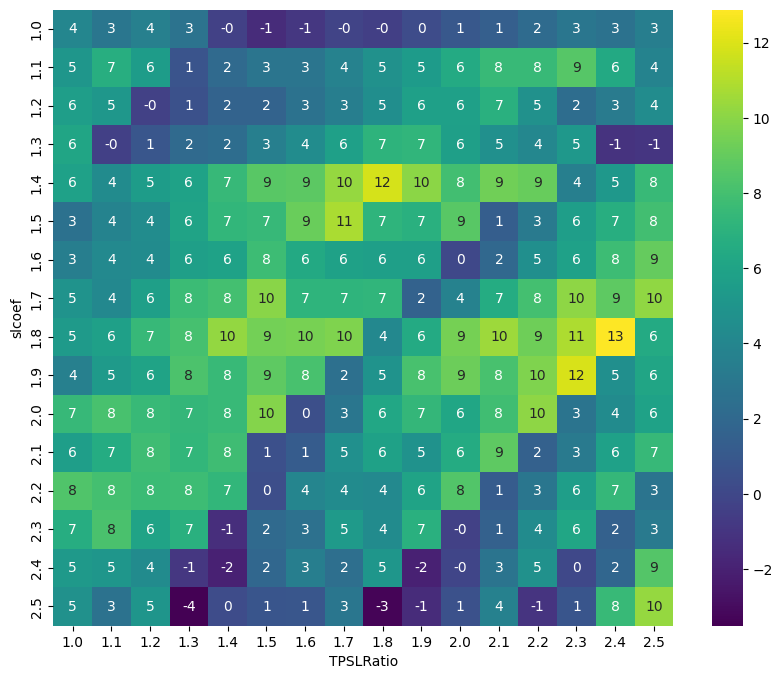

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()

## Equity percentage Lot/Trade size

In [ ]:
from backtesting import Strategy
from backtesting import Backtest

dfopt = df[-10000:-5000]
def SIGNAL():
    return dfopt.TotalSignal

class MyStrat(Strategy):
    mysize = 0.3 # 3000 previous fixed value
    slcoef = 1.1
    TPSLRatio = 1.5

    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio

        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)

        elif self.signal1==1 and len(self.trades)==0:
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dfopt, MyStrat, cash=250, margin=1/30)
stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 26)],
                    TPSLRatio=[i/10 for i in range(10, 26)],
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

Start                     2023-12-14 04:20:00
End                       2024-01-17 11:50:00
Duration                     34 days 07:30:00
Exposure Time [%]                       30.38
Equity Final [$]                   272.164792
Equity Peak [$]                    275.156638
Return [%]                           8.865917
Buy & Hold Return [%]                -0.23472
Return (Ann.) [%]                  112.384507
Volatility (Ann.) [%]               55.336585
Sharpe Ratio                         2.030926
Sortino Ratio                        8.611465
Calmar Ratio                        17.568061
Max. Drawdown [%]                   -6.397092
Avg. Drawdown [%]                   -0.822671
Max. Drawdown Duration       19 days 16:10:00
Avg. Drawdown Duration        0 days 22:10:00
# Trades                                   52
Win Rate [%]                        38.461538
Best Trade [%]                       0.390504
Worst Trade [%]                     -0.196359
Avg. Trade [%]                    

## Risk related Lot/Trade size

In [ ]:
from backtesting import Strategy
from backtesting import Backtest

dfopt = df[-10000:-5000]
def SIGNAL():
    return dfopt.TotalSignal

class MyStrat(Strategy):
    risk_perc = 0.05
    slcoef = 1.1
    TPSLRatio = 1.5

    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio

        #-------------------------------------------------------------
        #------ Lot sizing considering risk --------------------------
        pip_value = (1e-4 / self.data.Close[-1]) * 1e5
        size = int(self.risk_perc * self.equity / (slatr * pip_value))
        #print(self.equity, slatr, self.data.Close[-1], size)
        #ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo

        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=size)

        elif self.signal1==1 and len(self.trades)==0:
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=size)

bt = Backtest(dfopt, MyStrat, cash=250, margin=1/30)
stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 26)],
                    TPSLRatio=[i/10 for i in range(10, 26)],
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

Start                     2023-12-14 04:20:00
End                       2024-01-17 11:50:00
Duration                     34 days 07:30:00
Exposure Time [%]                       30.38
Equity Final [$]                   271.861101
Equity Peak [$]                    273.405881
Return [%]                            8.74444
Buy & Hold Return [%]                -0.23472
Return (Ann.) [%]                   114.11046
Volatility (Ann.) [%]               42.723735
Sharpe Ratio                         2.670892
Sortino Ratio                       11.112733
Calmar Ratio                        22.540144
Max. Drawdown [%]                   -5.062543
Avg. Drawdown [%]                   -0.555485
Max. Drawdown Duration       12 days 19:20:00
Avg. Drawdown Duration        0 days 16:45:00
# Trades                                   52
Win Rate [%]                        38.461538
Best Trade [%]                       0.390504
Worst Trade [%]                     -0.196359
Avg. Trade [%]                    

Let's say, for example, you are trading 1 standard lot of EUR/USD and the exchange rate is 1.2000:

- One Pip = 0.0001
- Exchange Rate = 1.2000
- Lot Size = 100,000
- Pip value = (0.0001 / 1.2000) * 100,000
- Pip value = $8.33

So, for every pip movement in the EUR/USD currency pair, the value would be $8.33

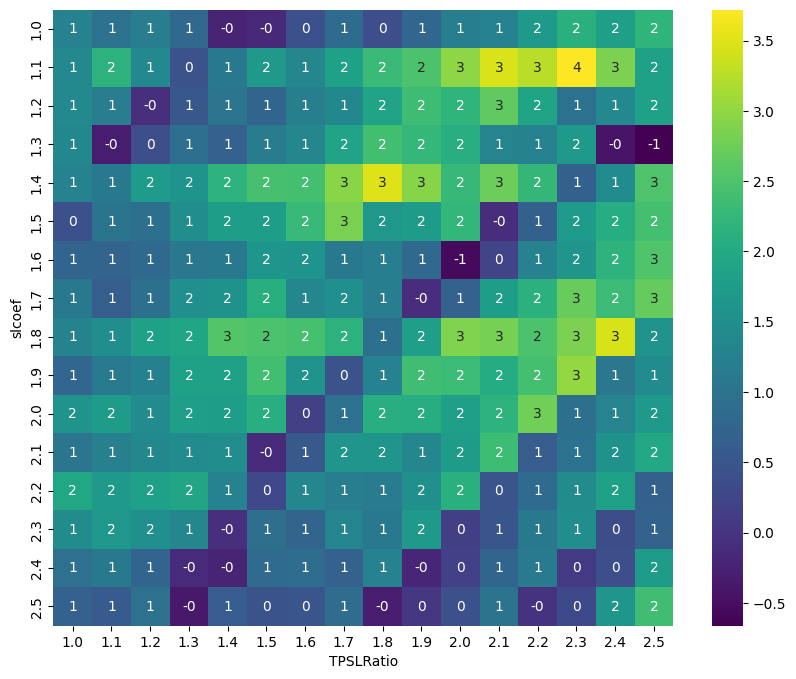

In [ ]:
# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()

In [ ]:
bt.plot()

f:\Python\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

f:\Python\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

f:\Python\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p1693', ...)

In [ ]:
stats._strategy

<Strategy MyStrat(slcoef=1.1,TPSLRatio=2.3)>